# Imports

In [82]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib

In [83]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Data loading

In [84]:
ML_FILE = "ml_trades_2024-07-24_10-48-33"

In [85]:
df = pd.read_csv(f"../data/processed/stockscreener/ml_datasets/{ML_FILE}.csv")

In [86]:
df['date'] = pd.to_datetime(df['date'], utc=True)

In [87]:
len(df[df["profit_binary"] == 1]) / len(df)

0.633976943560976

In [88]:
len(df)

119793

In [89]:
df.head()

,date,open,high,low,close,volume,in_index,earnings,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,cusip,rv,exit_date,trade_length
0,2010-06-30 00:00:00+00:00,33.97,34.4900,31.59,31.69,397902.0,True,True,0.0,0.0,34.4185,37.140413,31.696587,-0.001210,0.158166,14980.193,9.4,1.82,8556.2,NaN,1030.709961,0.068622,2109.239990,0.075663,9774.019531,0.061977,1245.500000,0.042212,18.671000,0.091248,75.629997,0.073330,NaN,86.019997,2.951,0.170,1.795,3.909,3.739,3.211100,0.497044,0.0,1.0,-0.022466,-0.786207,5.091054,32.705,31.971110,31.634947,43.855153,17.268892,29.088402,29.424703,18.189886,28.380624,23.035128,19.230806,27.465477,1.613355,-3.29,33.049679,NaN,36.401246,0.10,0.0,-9.405374,7.557778,22.991826,-196.663123,0.0,32.962792,1.931081,7.677187,100.0,50.000000,-50.000000,-0.014186,-0.040175,-0.036797,30.632952,33.2950,35.957048,15.990678,0.198540,0.73625,0.023830,0.017564,0.012500,0.021344,0.018286,0.017238,-0.268879,-0.046204,0.003431,0.474268,-0.046204,0.025550,-2.722610,53.729791,1.013018,125.445374,1,535555106,0,2010-08-04 00:00:00+00:00,24
1,2011-05-04 00:00:00+00:00,67.73,67.7800,62.94,64.76,311312.0,True,False,23.0,39.0,71.6195,76.084513,67.154487,-0.268139,0.124687,15557.539,9.0,2.55,8997.9,NaN,1347.319946,0.026470,2828.229980,0.032333,12723.580078,0.027808,1514.900024,0.036319,39.382999,0.160007,109.239998,0.255800,NaN,73.029999,3.223,0.020,1.937,4.329,4.309,3.415467,0.481096,0.0,0.0,-0.047201,-0.613636,5.007189,68.091,66.249708,65.206893,46.059124,4.909218,65.556909,29.667074,8.469753,54.849179,22.222461,11.418567,47.693819,3.242656,-8.04,69.129040,NaN,73.750000,0.12,0.0,-11.043956,12.059819,23.037583,-268.706896,0.0,68.360545,26.761291,40.443262,100.0,50.000000,-50.000000,-0.041311,-0.066796,-0.049697,62.656013,69.6025,76.548987,19.960451,0.151442,0.49750,0.022468,0.012494,0.026874,0.032704,0.031419,0.028260,-0.151703,-0.062811,0.017328,0.018242,-0.062811,0.036151,-4.190481,18.074091,0.512630,78.438865,1,535555106,0,2011-06-29 00:00:00+00:00,39
2,2011-07-27 00:00:00+00:00,68.00,68.0000,64.66,65.00,183920.0,True,False,18.0,55.0,69.7810,73.108004,66.453996,-0.218514,0.095356,15647.680,9.0,2.45,9211.2,NaN,1304.890015,0.045319,2764.790039,0.054327,12302.549805,0.039924,1615.000000,0.034166,40.553001,0.109493,97.400002,0.254777,NaN,74.089996,2.980,0.070,1.521,4.279,4.209,2.986267,0.450584,0.0,0.0,-0.051132,-0.898204,3.921822,67.655,66.460010,65.758536,41.392917,5.478272,45.919139,26.272056,8.954727,37.450750,20.575058,12.045104,32.692234,2.549184,-5.16,68.886828,NaN,72.193751,0.04,0.0,-7.354618,18.209657,33.068246,-281.552250,0.0,67.655169,35.196246,56.441594,100.0,0.000000,-100.000000,-0.057389,-0.050222,-0.032582,64.138862,68.5175,72.896138,12.781081,0.098334,-0.00125,0.025184,0.013273,0.030976,0.027665,0.026442,0.024504,-0.104826,-0.049847,0.019027,0.124631,-0.031843,0.021269,-5.267434,17.788033,0.974056,-167.624664,0,535555106,0,2011-10-24 00:00:00+00:00,62
3,2011-11-21 00:00:00+00:00,54.53,54.6800,52.50,53.07,91803.0,True,False,26.0,21.0,58.5455,63.036221,54.054779,-0.109646,0.153410,15842.259,8.6,1.90,9620.6,NaN,1192.979980

In [90]:
df = df.iloc[:,:-4]

In [91]:
df

,date,open,high,low,close,volume,in_index,earnings,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary
0,2010-06-30 00:00:00+00:00,33.97,34.4900,31.59,31.69,397902.0,True,True,0.0,0.0,34.4185,37.140413,31.696587,-0.001210,0.158166,14980.193,9.4,1.82,8556.2,NaN,1030.709961,0.068622,2109.239990,0.075663,9774.019531,0.061977,1245.500000,0.042212,18.671000,0.091248,75.629997,0.073330,NaN,86.019997,2.951,0.170,1.795,3.909,3.739,3.211100,0.497044,0.0,1.0,-0.022466,-0.786207,5.091054,32.705,31.971110,31.634947,43.855153,17.268892,29.088402,29.424703,18.189886,28.380624,23.035128,19.230806,27.465477,1.613355,-3.29,33.049679,NaN,36.401246,0.10,0.0,-9.405374,7.557778,22.991826,-196.663123,0.0,32.962792,1.931081,7.677187,100.000000,50.000000,-50.000000,-0.014186,-0.040175,-0.036797,30.632952,33.2950,35.957048,15.990678,0.198540,0.73625,0.023830,0.017564,0.012500,0.021344,0.018286,0.017238,-0.268879,-0.046204,0.003431,0.474268,-0.046204,0.025550,-2.722610,53.729791,1.013018,125.445374,1
1,2011-05-04 00:00:00+00:00,67.73,67.7800,62.94,64.76,311312.0,True,False,23.0,39.0,71.6195,76.084513,67.154487,-0.268139,0.124687,15557.539,9.0,2.55,8997.9,NaN,1347.319946,0.026470,2828.229980,0.032333,12723.580078,0.027808,1514.900024,0.036319,39.382999,0.160007,109.239998,0.255800,NaN,73.029999,3.223,0.020,1.937,4.329,4.309,3.415467,0.481096,0.0,0.0,-0.047201,-0.613636,5.007189,68.091,66.249708,65.206893,46.059124,4.909218,65.556909,29.667074,8.469753,54.849179,22.222461,11.418567,47.693819,3.242656,-8.04,69.129040,NaN,73.750000,0.12,0.0,-11.043956,12.059819,23.037583,-268.706896,0.0,68.360545,26.761291,40.443262,100.000000,50.000000,-50.000000,-0.041311,-0.066796,-0.049697,62.656013,69.6025,76.548987,19.960451,0.151442,0.49750,0.022468,0.012494,0.026874,0.032704,0.031419,0.028260,-0.151703,-0.062811,0.017328,0.018242,-0.062811,0.036151,-4.190481,18.074091,0.512630,78.438865,1
2,2011-07-27 00:00:00+00:00,68.00,68.0000,64.66,65.00,183920.0,True,False,18.0,55.0,69.7810,73.108004,66.453996,-0.218514,0.095356,15647.680,9.0,2.45,9211.2,NaN,1304.890015,0.045319,2764.790039,0.054327,12302.549805,0.039924,1615.000000,0.034166,40.553001,0.109493,97.400002,0.254777,NaN,74.089996,2.980,0.070,1.521,4.279,4.209,2.986267,0.450584,0.0,0.0,-0.051132,-0.898204,3.921822,67.655,66.460010,65.758536,41.392917,5.478272,45.919139,26.272056,8.954727,37.450750,20.575058,12.045104,32.692234,2.549184,-5.16,68.886828,NaN,72.193751,0.04,0.0,-7.354618,18.209657,33.068246,-281.552250,0.0,67.655169,35.196246,56.441594,100.000000,0.000000,-100.000000,-0.057389,-0.050222,-0.032582,64.138862,68.5175,72.896138,12.781081,0.098334,-0.00125,0.025184,0.013273,0.030976,0.027665,0.026442,0.024504,-0.104826,-0.049847,0.019027,0.124631,-0.031843,0.021269,-5.267434,17.788033,0.974056,-167.624664,0
3,2011-11-21 00:00:00+00:00,54.53,54.6800,52.50,53.07,91803.0,True,False,26.0,21.0,58.5455,63.036221,54.054779,-0.109646,0.153410,15842.259,8.6,1.90,9620.6,NaN,1192.979980,0.083729,2523.139893,0.083902,11547.309570,0.076630,1678.300049,0.070518,31.113001,0.142808,96.919998,0.189225,NaN,78.300003,1.962,0.005,0.

In [92]:
df["profit"] = df["profit"] / 1000

# Data preprocessing

### Combine PSAR columns

In [93]:
df['PSAR_0.02_0.2'] = df['PSARl_0.02_0.2'].fillna(0) + df['PSARs_0.02_0.2'].fillna(0)
df.drop(columns=['PSARl_0.02_0.2', 'PSARs_0.02_0.2'], inplace=True)

### Fill NA values in columns with frequent NAs

In [94]:
df.fillna({'CryptoMarketCap':0, 'BTC': 0, 'from_earnings': 100, 'to_earnings': 100}, inplace=True)

### Check for any leftover NAs and deal with them

In [95]:
df.isnull().any().any()

True

In [96]:
df = df.fillna(0)

In [97]:
df.isnull().any().any()

False

### Convert all feature columns to float

In [98]:
df = df.astype({col: 'Float32' for col in df.columns[1:]})

In [99]:
df.head()

,date,open,high,low,close,volume,in_index,earnings,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,PSAR_0.02_0.2
0,2010-06-30 00:00:00+00:00,33.970001,34.490002,31.59,31.690001,397902.0,1.0,1.0,0.0,0.0,34.418499,37.140411,31.696587,-0.00121,0.158166,14980.193359,9.4,1.82,8556.200195,0.0,1030.709961,0.068622,2109.23999,0.075663,9774.019531,0.061977,1245.5,0.042212,18.671,0.091248,75.629997,0.07333,0.0,86.019997,2.951,0.17,1.795,3.909,3.739,3.2111,0.497044,0.0,1.0,-0.022466,-0.786207,5.091054,32.705002,31.971111,31.634947,43.855152,17.268892,29.088402,29.424704,18.189886,28.380625,23.035128,19.230806,27.465477,1.613355,-3.29,33.049679,0.1,0.0,-9.405375,7.557778,22.991825,-196.663116,0.0,32.962791,1.931082,7.677187,100.0,50.0,-50.0,-0.014186,-0.040175,-0.036797,30.632952,33.294998,35.957047,15.990678,0.19854,0.73625,0.02383,0.017564,0.0125,0.021344,0.018286,0.017238,-0.268879,-0.046204,0.003431,0.474268,-0.046204,0.02555,-2.72261,53.72979,1.013018,0.125445,1.0,36.401245
1,2011-05-04 00:00:00+00:00,67.730003,67.779999,62.939999,64.760002,311312.0,1.0,0.0,23.0,39.0,71.619499,76.084511,67.154488,-0.268139,0.124687,15557.539062,9.0,2.55,8997.900391,0.0,1347.319946,0.02647,2828.22998,0.032333,12723.580078,0.027808,1514.900024,0.036319,39.382999,0.160007,109.239998,0.2558,0.0,73.029999,3.223,0.02,1.937,4.329,4.309,3.415467,0.481096,0.0,0.0,-0.047201,-0.613636,5.007189,68.091003,66.24971,65.206894,46.059124,4.909218,65.556908,29.667074,8.469753,54.849178,22.222462,11.418567,47.693817,3.242656,-8.04,69.129044,0.12,0.0,-11.043956,12.059819,23.037582,-268.706909,0.0,68.360542,26.761292,40.443264,100.0,50.0,-50.0,-0.041311,-0.066796,-0.049697,62.656013,69.602501,76.548988,19.960451,0.151442,0.4975,0.022468,0.012494,0.026874,0.032704,0.031419,0.02826,-0.151703,-0.062811,0.017328,0.018242,-0.062811,0.036151,-4.190481,18.074091,0.51263,0.078439,1.0,73.75
2,2011-07-27 00:00:00+00:00,68.0,68.0,64.660004,65.0,183920.0,1.0,0.0,18.0,55.0,69.780998,73.108002,66.453995,-0.218514,0.095356,15647.679688,9.0,2.45,9211.200195,0.0,1304.890015,0.045319,2764.790039,0.054327,12302.549805,0.039924,1615.0,0.034166,40.553001,0.109493,97.400002,0.254777,0.0,74.089996,2.98,0.07,1.521,4.279,4.209,2.986267,0.450584,0.0,0.0,-0.051132,-0.898204,3.921822,67.654999,66.460007,65.758537,41.392918,5.478271,45.91914,26.272057,8.954727,37.450752,20.575058,12.045104,32.692234,2.549184,-5.16,68.886826,0.04,0.0,-7.354618,18.209658,33.068245,-281.552246,0.0,67.655167,35.196247,56.441593,100.0,0.0,-100.0,-0.057389,-0.050222,-0.032582,64.138863,68.517502,72.896141,12.78108,0.098334,-0.00125,0.025184,0.013273,0.030976,0.027665,0.026442,0.024504,-0.104826,-0.049847,0.019027,0.124631,-0.031843,0.021269,-5.267434,17.788033,0.974056,-0.167625,0.0,72.193748
3,2011-11-21 00:00:00+00:00,54.529999,54.68,52.5,53.07,91803.0,1.0,0.0,26.0,21.0,58.545502,63.036221,54.054779,-0.109646,0.15341,15842.258789,8.6,1.9,9620.599609,0.0,1192.97998,0.083729,2523.139893,0.083902,11547.30957,0.07663,1678.300049,0.070518,31.113001,0.142808,96.919998,0.189225,0.0,78.300003,1.962,0.005,0.906,2.945,2.94,2.1127,0.515087,0.0,0.0,-0.054454,-0.6

# Create train/test split

In [100]:
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)

Split dataframe to approximately 80/20 train/test. Should be disabled, if training for a live model to allow for more training data.

In [101]:
split_date = df.at[int(len(df)*0.8),"date"]
split_date = pd.to_datetime("2020-01-01", utc=True)

In [102]:
train_set = df[df['date'] < split_date]
test_set = df[df['date'] >= split_date]

In [103]:
X_train = train_set.loc[:, ~train_set.columns.isin(['date', 'profit', 'profit_binary'])]
y_train = train_set.loc[:, 'profit_binary']

In [104]:
X_test = test_set.loc[:, ~test_set.columns.isin(['date', 'profit', 'profit_binary'])]
y_test = test_set.loc[:, 'profit_binary']

# Train Meta Model

In [105]:
cfg = {
    "num_threads": 8,
    "boosting_type": "gbdt",
    "lambda_l1": 2.8269687100646643,
    "lambda_l2": 0.1132729746179371,
    "num_leaves": 100,
    #"num_leaves": 222,
    "feature_fraction": 0.6029600980261194,
    "bagging_fraction": 0.9924346775670325,
    "bagging_freq": 2,
    "min_child_samples": 65,
    "max_depth": 14,
    "max_bin": 136,
    "learning_rate": 0.30197097330510875,
    "importance_type": "gain"
}

clf = lgb.LGBMClassifier(seed=42)

clf.set_params(**cfg)
trained_clf = clf.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6029600980261194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6029600980261194
[LightGBM] [Warning] lambda_l1 is set=2.8269687100646643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8269687100646643
[LightGBM] [Warning] lambda_l2 is set=0.1132729746179371, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1132729746179371
[LightGBM] [Warning] bagging_fraction is set=0.9924346775670325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9924346775670325
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6029600980261194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6029600980261194
[LightGBM] [Warning] lambda_l1 is set=2.8269687100646643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8269687100646643
[LightGBM] [Warning] lambda_l2 is set

In [106]:
ypred = trained_clf.predict(X_test)
ypred

[LightGBM] [Warning] feature_fraction is set=0.6029600980261194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6029600980261194
[LightGBM] [Warning] lambda_l1 is set=2.8269687100646643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8269687100646643
[LightGBM] [Warning] lambda_l2 is set=0.1132729746179371, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1132729746179371
[LightGBM] [Warning] bagging_fraction is set=0.9924346775670325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9924346775670325
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


array([0., 0., 0., ..., 1., 0., 1.])

In [107]:
pred_df = pd.DataFrame(data = [ypred, y_test.to_numpy()]).T
pred_df.columns = ["prediction", "target"]

In [108]:
pred_df

,prediction,target
0,0.0,0.0
1,0.0,0.0
2,0.0,1.0
3,1.0,1.0
4,0.0,1.0
...,...,...
37017,0.0,1.0
37018,0.0,1.0
37019,1.0,1.0
37020,0.0,1.0


In [109]:
len(pred_df[pred_df['target'] == pred_df['prediction']]) / len(pred_df)

0.5428393927934742

In [110]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
# Direct class predictions
y_pred = clf.predict(X_test)
# Confusion matrix
print("Confusion Matrix for Direct Predictions:")
print(confusion_matrix(y_test, y_pred))
# Precision, recall, f1-score
print("\nClassification Report for Direct Predictions:")
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] feature_fraction is set=0.6029600980261194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6029600980261194
[LightGBM] [Warning] lambda_l1 is set=2.8269687100646643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8269687100646643
[LightGBM] [Warning] lambda_l2 is set=0.1132729746179371, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1132729746179371
[LightGBM] [Warning] bagging_fraction is set=0.9924346775670325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9924346775670325
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Confusion Matrix for Direct Predictions:
[[ 5624  9232]
 [ 7693 14473]]

Classification Report for Direct Predictions:
              precision    recall  f1-score   support

         0.0       0.42      0.38      0.40     14856
         1.0       0.61      0.65      0.63     22166

    accuracy                           0.

In [111]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]
# Applying threshold of 0.8 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.8).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.8 Threshold:")
print(confusion_matrix(y_test, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.8 Threshold:")
print(classification_report(y_test, y_pred_threshold))

[LightGBM] [Warning] feature_fraction is set=0.6029600980261194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6029600980261194
[LightGBM] [Warning] lambda_l1 is set=2.8269687100646643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8269687100646643
[LightGBM] [Warning] lambda_l2 is set=0.1132729746179371, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1132729746179371
[LightGBM] [Warning] bagging_fraction is set=0.9924346775670325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9924346775670325
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Confusion Matrix with 0.8 Threshold:
[[13385  1471]
 [19822  2344]]

Classification Report with 0.8 Threshold:
              precision    recall  f1-score   support

         0.0       0.40      0.90      0.56     14856
         1.0       0.61      0.11      0.18     22166

    accuracy                           0.42     3

In [112]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]
# Applying threshold of 0.9 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.9).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.9 Threshold:")
print(confusion_matrix(y_test, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.9 Threshold:")
print(classification_report(y_test, y_pred_threshold))

[LightGBM] [Warning] feature_fraction is set=0.6029600980261194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6029600980261194
[LightGBM] [Warning] lambda_l1 is set=2.8269687100646643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8269687100646643
[LightGBM] [Warning] lambda_l2 is set=0.1132729746179371, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1132729746179371
[LightGBM] [Warning] bagging_fraction is set=0.9924346775670325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9924346775670325
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Confusion Matrix with 0.9 Threshold:
[[14630   226]
 [21787   379]]

Classification Report with 0.9 Threshold:
              precision    recall  f1-score   support

         0.0       0.40      0.98      0.57     14856
         1.0       0.63      0.02      0.03     22166

    accuracy                           0.41     3

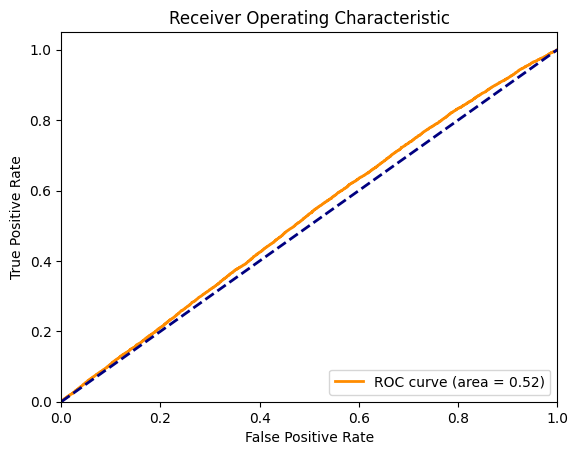

In [113]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [114]:
ypred = trained_clf.predict_proba(X_test)[:,1]
column_names = test_set.columns.to_list()
column_names.append("pred")
test_set_with_preds = pd.DataFrame(data = np.c_[test_set.to_numpy(), ypred])
test_set_with_preds.columns = column_names

[LightGBM] [Warning] feature_fraction is set=0.6029600980261194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6029600980261194
[LightGBM] [Warning] lambda_l1 is set=2.8269687100646643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8269687100646643
[LightGBM] [Warning] lambda_l2 is set=0.1132729746179371, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1132729746179371
[LightGBM] [Warning] bagging_fraction is set=0.9924346775670325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9924346775670325
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [115]:
test_set_with_preds

,date,open,high,low,close,volume,in_index,earnings,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,PSAR_0.02_0.2,pred
0,2020-01-02 00:00:00+00:00,16.51,16.549999,16.4,16.4,290207.0,1.0,0.0,33.0,47.0,16.4795,16.557404,16.401596,-0.010245,0.009455,21706.513672,3.6,1.8,15452.400391,6945.009766,3257.850098,0.018261,9092.19043,0.021896,28868.800781,0.020299,1524.5,0.021243,17.966,0.04776,61.18,0.080008,6985.470215,96.849998,1.882,1.495,1.671,2.341,0.846,1.836667,0.216167,1.0,0.0,-0.006079,-0.733333,0.582283,16.464001,16.439886,16.419191,46.112793,8.111035,30.927477,55.687504,13.490148,23.588238,65.592323,22.783339,18.193266,0.095494,-0.19,16.493475,0.02,1.0,-1.145268,23.543882,49.937866,-96.387512,0.0,16.467325,19.84127,35.343487,100.0,71.428574,-28.571428,-0.007702,-0.003885,-0.003661,16.386192,16.48,16.573809,1.13845,0.073599,0.0175,0.002307,0.003442,0.003713,0.003479,0.004007,0.003624,-0.069034,-0.006061,0.004237,0.316651,-0.001211,0.003359,-2.987636,1.274371,1.773116,-0.096898,0.0,16.610001,0.497444
1,2020-01-02 00:00:00+00:00,15.69,15.7,15.22,15.39,1237863.0,1.0,0.0,38.0,36.0,15.995,16.550823,15.439177,-0.044237,0.0695,21706.513672,3.6,1.8,15452.400391,6945.009766,3257.850098,0.018261,9092.19043,0.021896,28868.800781,0.020299,1524.5,0.021243,17.966,0.04776,61.18,0.080008,6985.470215,96.849998,1.882,1.495,1.671,2.341,0.846,1.836667,0.216167,1.0,0.0,-0.014194,-0.625,2.033376,15.549,15.452486,15.412815,55.588341,3.156514,41.30434,50.275898,5.376402,36.608265,46.300125,7.182968,35.095654,0.312937,-0.49,15.595213,0.02,1.0,-3.085642,7.933014,18.151415,-233.774414,0.0,15.585238,12.441966,21.024015,100.0,7.142857,-92.85714,-0.018498,-0.008849,-0.010239,15.298948,15.6175,15.936051,4.079416,0.142915,0.20375,0.010527,0.009131,0.007223,0.00688,0.007417,0.007158,-0.19431,-0.014094,0.005031,0.780716,-0.00128,0.006587,-3.337018,3.325769,0.569187,-0.708706,0.0,16.4,0.476887
2,2020-01-02 00:00:00+00:00,41.299999,41.299999,38.580002,38.990002,562733.0,1.0,0.0,38.0,37.0,42.051498,45.04089,39.062111,-0.012061,0.142178,21706.513672,3.6,1.8,15452.400391,6945.009766,3257.850098,0.018261,9092.19043,0.021896,28868.800781,0.020299,1524.5,0.021243,17.966,0.04776,61.18,0.080008,6985.470215,96.849998,1.882,1.495,1.671,2.341,0.846,1.836667,0.216167,1.0,0.0,-0.049535,-0.849265,4.690041,40.063,39.572433,39.368343,50.570488,5.020203,38.086166,38.268269,7.356922,33.361259,28.834732,9.426467,30.675608,1.828647,-2.39,40.916931,0.06,0.0,-5.775737,18.863564,32.534927,-156.836014,0.0,40.177345,31.368944,39.386471,100.0,35.714287,-64.285713,-0.068988,-0.022715,-0.017191,38.755436,40.2775,41.799564,7.557881,0.077054,1.07125,0.03245,0.041267,0.031843,0.02627,0.022049,0.020956,-0.139578,-0.048328,0.014831,0.388144,0.008865,0.015202,-4.447784,21.006163,5.371861,0.144179,1.0,43.795437,0.309851
3,2020-01-02 00:00:00+00:00,21.780001,21.82,21.165001,21.24,947065.0,1.0,0.0,37.0,23.0,21.661501,22.079412,21.243587,-0.004292,0.038586,21706.513672,3.6,1.8,15452.400391,6945.009766,3257.850098,0.018261,9092.19043,0.021896,28868.800781,0.020299,1524.5,0.021243,17.966,0.04776,61.18,0.080008,6985.470215,96.849998,1

In [116]:
# profit factor whole dataset
print("Test set base PF:")
print(sum(test_set_with_preds[test_set_with_preds["profit"] > 0]["profit"]) / abs(sum(test_set_with_preds[test_set_with_preds["profit"] <= 0]["profit"])))
print("")

# profit factor with model predictions
print("Test set with > 0.5 PF:")
pred_set = test_set_with_preds[test_set_with_preds["pred"] > 0.5]
print(sum(pred_set[pred_set["profit"] > 0]["profit"]) / abs(sum(pred_set[pred_set["profit"] <= 0]["profit"])))
print("")

print("Test set with > 0.8 PF:")
pred_set = test_set_with_preds[test_set_with_preds["pred"] > 0.8]
print(sum(pred_set[pred_set["profit"] > 0]["profit"]) / abs(sum(pred_set[pred_set["profit"] <= 0]["profit"])))
print("")

print("Test set with > 0.9 PF:")
pred_set = test_set_with_preds[test_set_with_preds["pred"] > 0.9]
print(sum(pred_set[pred_set["profit"] > 0]["profit"]) / abs(sum(pred_set[pred_set["profit"] <= 0]["profit"])))
print("")

Test set base PF:
1.0205926609798757

Test set with > 0.5 PF:
1.0581655847457965

Test set with > 0.8 PF:
1.266292291756569

Test set with > 0.9 PF:
1.7861408066982198



In [117]:
def save_model_sklearn(model_name: str):
    """
    Saves models from sklearn to filesystem.

    Args:
        model (sklearn model): Sklearn model.
        path (string): The path to save the model to.
        model_name (string): The name of the model.
    """
    joblib.dump(trained_clf, f'../data/processed/stockscreener/ml_model/{model_name}.joblib')

In [118]:
save_model_sklearn('meta_model_adx_v3')